In [280]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.transform import resize
from easydict import EasyDict
%matplotlib inline

Our object detection system, called Faster R-CNN, is composed of two modules. The first module is a deep
fully convolutional network that proposes regions, and the second module is the Fast R-CNN detector ... that uses the proposed regions. The entire system is a single, unified network for object detection (Figure 2).

TODO: Add figure

# Bounding boxes

> Bounding boxes can be represented in a number ways. We will use the $xyxy$ format where the box is represented by its top-left and bottom-right corner co-ordinates $[x_1, y_1, x_2, y_2]$  and the $whxy$  format where we specify the width, height, and $x$ and $y$ coordinates of the centre, $[w, h, x_\text{centre}, y_\text{centre}]$. Note that $x_2$ and $y_2$ are *inside* the box.

In [281]:
def to_whxy(box):
    # [..., 4]
    """Return width, height, x center, and y center for an anchor (window)."""
    
    # Add 1 to get dims since x2,y2 inside 
    w = box[..., 2] - box[..., 0] + 1
    h = box[..., 3] - box[..., 1] + 1
    x_ctr = box[..., 0] + 0.5 * (w - 1)
    y_ctr = box[..., 1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr # [...]


In [282]:
def plot_rectangle(box, ax=None, clr='b', linewidth=1):
    x1, y1, x2, y2 = box
    w, h, xc, yc = to_whxy(box)
    # -1 because box is plotted between x1 to x1 + w when we want x1 to x1 + w - 1
    ax.add_artist(plt.Rectangle(xy=(x1, y1), height=h-1, width=w-1, fill=False, color=clr,
                               linewidth=linewidth))
    
    
#     ax.plot(xc, yc, 'x')
#     for x in [x1, x2]:
#         for y in [y1, y2]:
#             ax.plot(x, y, '.')
    

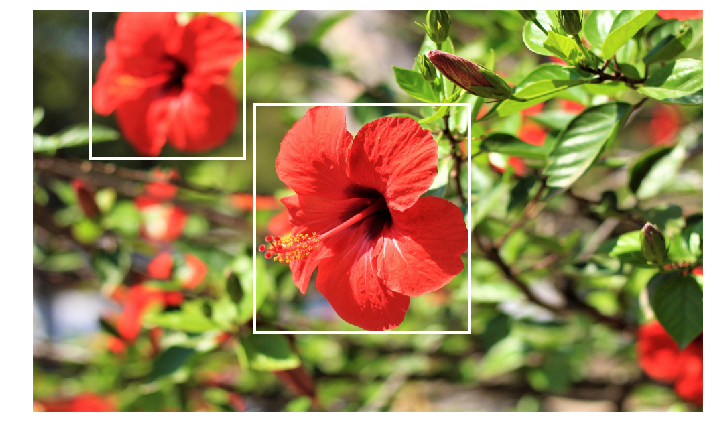

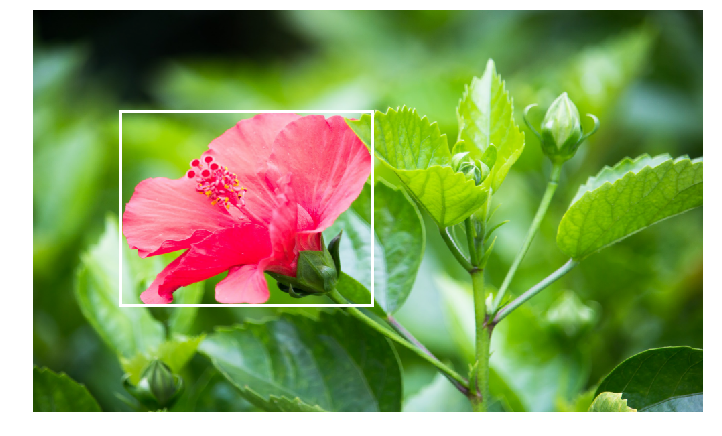

In [288]:
img = plt.imread('hibiscus-3601937_1920.jpg')
img = resize(img, (600, 1000))
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)
ax.axis('off');
bbox1 = [85,   0, 315, 220]
bbox2 = [330,   140, 650, 480]
plot_rectangle(np.stack(bbox1), ax=ax, clr='w', linewidth=3);
plot_rectangle(np.stack(bbox2), ax=ax, clr='w', linewidth=3);

img2 = plt.imread('flowers-4365828_1920.jpg')
img2 = resize(img2, (600, 1000))
bbox3 = [130,   150, 505, 440]
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img2)
ax.axis('off');
plot_rectangle(np.stack(bbox3), ax=ax, clr='w', linewidth=3);

# Region Proposal Networks

A Region Proposal Network (RPN) takes an image (of any size) as input and outputs a set of rectangular object proposals, each with an objectness score. We model this process with a fully convolutional network, which we describe in this section. Because our ultimate goal is to share computation with a Fast R-CNN object detection network, we assume that both nets share a common set of convolutional layers. 

> *Both the RPN and the Fast R-CNN detection network share a "backbone" feature extractors whose feature maps are used for the subsequent steps. In the original Faster R-CNN paper the extract feature maps from just the final convolutional layer of the backbone network but later works use feature pyramids. We will subsequently look at how feature pyramids are extracted.*

To generate region proposals, we slide a small network over the convolutional feature map output by the last shared convolutional layer. This small network takes as input an n × n spatial window of the input convolutional feature map. Each sliding window is mapped to a lower-dimensional feature. This feature is fed into two sibling fully- connected layers—a box-regression layer (reg) and a box-classification layer (cls). We use n = 3 in this paper, noting that the effective receptive field on the input image is large. This mini-network is illustrated at a single position in Figure 3 (left). Note that because the mini-network operates in a sliding-window fashion, the fully-connected layers are shared across all spatial locations. This architecture is naturally implemented with an $n \times n$ convolutional layer followed by two sibling $1 \times 1$ convolutional layers (for reg and cls, respectively).

At each sliding-window location, we simultaneously predict multiple region proposals, where the number of maximum possible proposals for each location is denoted as $k$. So the reg layer has 4k outputs encoding the coordinates of $k$ boxes, and the cls layer outputs $2k$ scores that estimate probability of object or not object for each proposal4. The $k$ proposals are parameterized relative to $k$ reference boxes, which we call anchors. 

In our formula- tion, the features used for regression are of the same spatial size (3 × 3) on the feature maps. To account for varying sizes, a set of k bounding-box regressors are learned. Each regressor is responsible for one scale and one aspect ratio, and the k regressors do not share weights. As such, it is still possible to predict boxes of various sizes even though the features are of a fixed size/scale, thanks to the design of anchors.

In [289]:
def rpn_head(inputs, num_anchors, filters=256, kernel_size=3):
    """
    A = num_anchors
    F = filters (in first conv layer)
    B = batch_size
    H = height
    W = width
    """
    # (B, H, W, F)
    inputs = tf.layers.conv2d(inputs, filters=filters, kernel_size=kernel_size, padding="same")
    # (B, H, W, 4*A)
    deltas = tf.layers.dense(inputs, units=4 * num_anchors)
    # (B, H, W, A)
    scores = tf.layers.dense(inputs, units=num_anchors)
    # (B, H*W*A, 4)
    deltas = tf.reshape(deltas, [tf.shape(deltas)[0], -1, 4])
    # (B, H*W*A)
    scores = tf.reshape(deltas, [tf.shape(deltas)[0], -1])
    return deltas, scores

# Anchor boxes

[W]e introduce novel “anchor” boxes that serve as references at multiple scales and aspect ratios.

An anchor is centered at the sliding window in question, and is associated with a scale and aspect ratio (Figure 3, left). By default we use 3 scales and 3 aspect ratios, yielding k = 9 anchors at each sliding position.

> Each pixel in the input feature map corresponds to an anchor box. Here we will adapt FaceBook's MRCNN benchmark anchor generation code. First we define a single `anchor` with dimensions $[x_1, y_1, x_2, y_2] = [0, 0, s-1, s-1]$, where $s$ is the stride of the feature map with respect to the input.

In [290]:
def generate_anchors(
    stride=16, sizes=(128, 256, 512), aspect_ratios=(0.5, 1, 2)):
    
    sizes = np.array(sizes)
    aspect_ratios = np.array(aspect_ratios)
    
    base_anchor = np.array([1, 1, stride, stride], dtype=np.float) - 1 # (1,)
    w, h, x_ctr, y_ctr =  to_whxy(base_anchor) # (1,)
    base_area = w * h
    
    
    widths = np.round(np.sqrt(base_area / aspect_ratios)) # (A,)
    heights = np.round(widths * aspect_ratios) # (A,)
    
    scales = sizes / stride
    widths = scales[None] * widths[:, None] # (A, S)
    heights = scales[None] * heights[:, None]  # (A, S)
    
    # Each is (A, S)
    x1 = x_ctr - 0.5 * (widths - 1)
    y1 = y_ctr - 0.5 * (heights - 1)
    x2 = x_ctr + 0.5 * (widths - 1)
    y2 = y_ctr + 0.5 * (heights - 1)
    
    anchors = np.stack([x1, y1, x2, y2], axis=-1) #(A, S, 4)
    
    return np.reshape(anchors, [-1, 4]) # (A*S, 4)

For anchors, we use 3 scales with box areas of 1282,
2562, and 5122 pixels, and 3 aspect ratios of 1:1, 1:2, and 2:1. To generate region proposals, we slide a small network over the convolutional feature map output by the last shared convolutional layer ... the total stride ... on the last convolutional layer is 16 pixels.

In [326]:
anchors = generate_anchors(stride=16, sizes=(128, 256, 512), 
                          aspect_ratios=(0.5, 1., 2.))

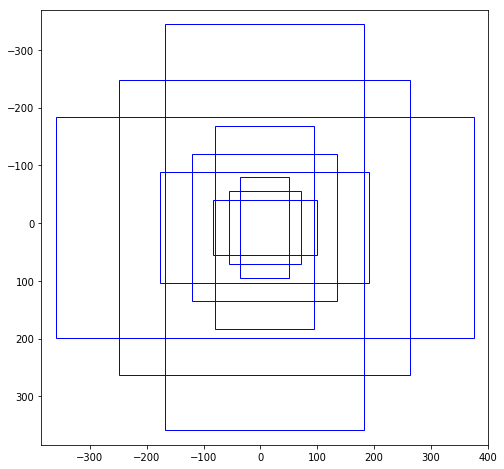

In [327]:
fig, ax = plt.subplots(1, figsize=(8,8))

for box in anchors:
    plot_rectangle(box, ax, linewidth=1);
    
plt.xlim(anchors[:, 0].min() - 25, anchors[:, 2].max() + 25)
plt.ylim(anchors[:, 1].min() - 25, anchors[:, 3].max() + 25);
ax.invert_yaxis();

For a convolutional feature map of a size $W \times H$ ... there are $WHk$ anchors in total.

> A grid of anchors is constructed by shifting the base anchor boxes across the feature map with a shift per pixel of the stride $s$. 

The anchor boxes that cross image boundaries need
to be handled with care. During training, we ignore all cross-boundary anchors so they do not contribute to the loss. For a typical 1000 × 600 image, there will be roughly 20000 (≈ 60 × 40 × 9) anchors in total. With the cross-boundary anchors ignored, there are about 6000 anchors per image for training. 

In [328]:
def grid_anchors(base_anchors, stride, width, height, img_width, img_height):
    """
    base_anchors: (N, 4)
    H = height
    W = width
    """
    shifts_x = np.arange(0, width * stride, stride) # (W,)
    shifts_y = np.arange(0, height * stride, stride) # (H,)
    
    # Indexing is 'xy' by default in np/tf but 'ij' in pytorch 
    # (so they reverse these in the mrcnn benchmark code)
    shifts_x, shifts_y = np.meshgrid(shifts_x, shifts_y) 
    
    shifts = np.stack([shifts_x, shifts_y, shifts_x, shifts_y], axis=-1) # (H, W, 4)
    
    # (H, W, 1, 4) + (1, 1, N, 4) -> (H, W, N, 4)
    anchors = shifts[..., None, :] + base_anchors[None, None]
    
    inside = (anchors[..., :2] >= [0, 0]).all(axis=-1) & (anchors[..., 2:] < [img_width, img_height]).all(axis=-1)
    
    return anchors, inside

In [329]:
grid_1000_600, inside_1000_600 = grid_anchors(anchors, 16, 1000 // 16, 600 // 16, 1000, 600)
grid_1000_600.size // 4, inside_1000_600.sum()

(20646, 8151)

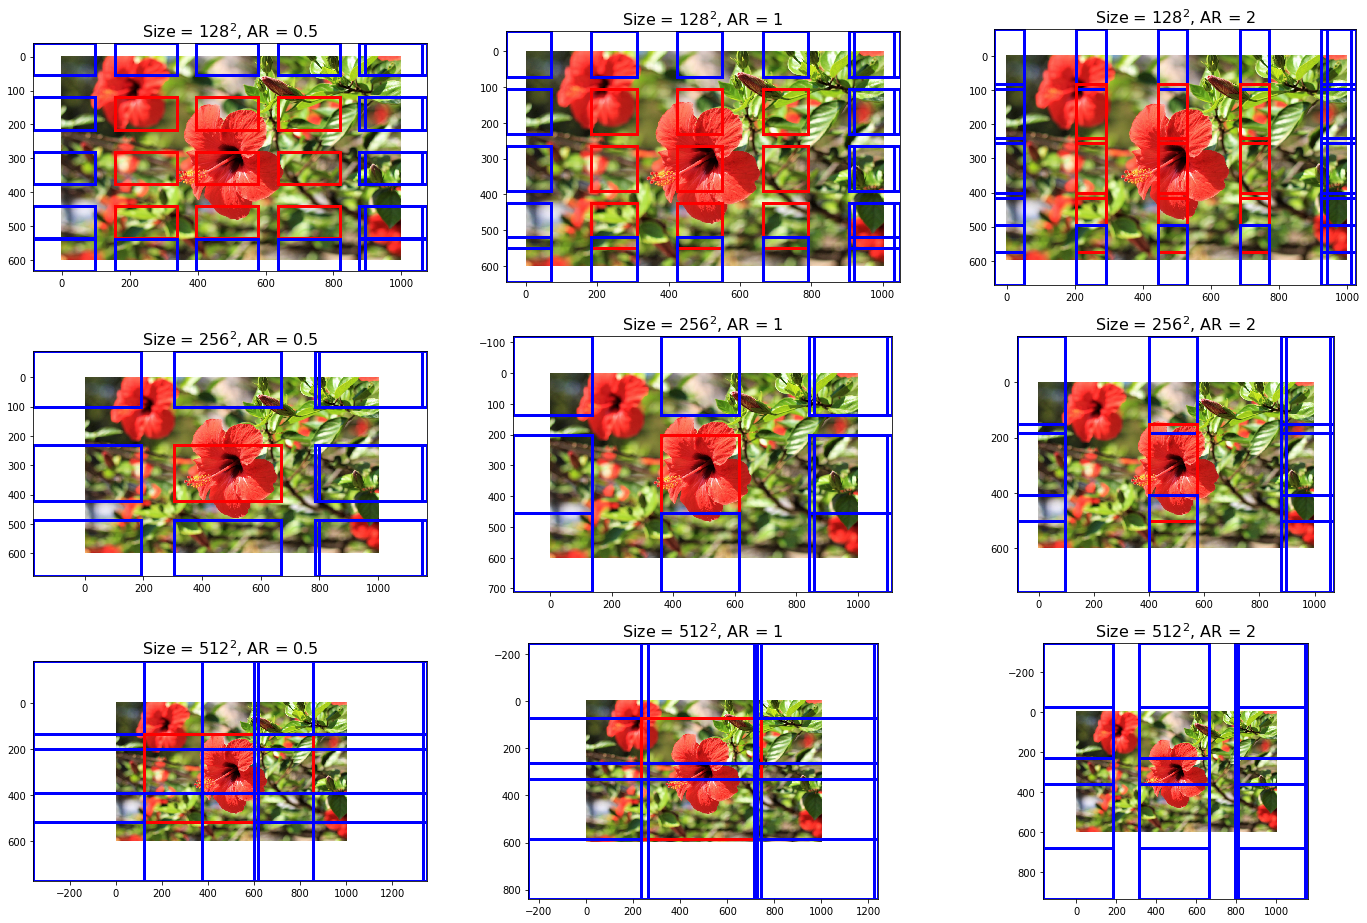

In [346]:
sizes=(128, 256, 512)
aspect_ratios=(0.5, 1, 2)
grid, inside = grid_anchors(generate_anchors(sizes=sizes, aspect_ratios=aspect_ratios), 16,
                            width=img.shape[1]//16, height=img.shape[0]//16,
                            img_width=img.shape[1], img_height=img.shape[0])
# Sample the grid and also add the left-most and bottom-most boxes as well

sample1 = [10, 20, 20]
sample2 = [15, 30, 30]

def plot_anchors(grid, inside, sizes, aspect_ratios, sample_h, sample_w, images=None):
    
    fig, axes = plt.subplots(len(sizes), len(aspect_ratios), figsize=(24, 16))
    if len(sizes) == 1:
        axes = axes[None]
    
    for i, ar in enumerate(aspect_ratios):
        for j, sz in enumerate(sizes):
            ax = axes[j, i]
            ax.imshow(img)

            n = i * 3 + j

            s1 = sample_h[j]
            s2 = sample_w[j]

            boxes = np.concatenate([
                grid[::s1, ::s2, n].reshape((-1, 4)),
                grid[-1:, ::s2, n].reshape((-1, 4)),
                grid[::s1, -1:, n].reshape((-1, 4)),
                grid[-1:, -1:, n].reshape((-1, 4))])

            boxes_inside = np.concatenate([
                inside[::s1, ::s2, n].reshape((-1)),
                inside[-1:, ::s2, n].reshape((-1)),
                inside[::s1, -1:, n].reshape((-1)),
                inside[-1:, -1:, n].reshape((-1))])
            
            for box, box_in in zip(boxes, boxes_inside):
                plot_rectangle(box, ax, clr='r' if box_in else 'b', linewidth=3)
            ax.set_title('Size = ${}^2$, AR = ${}$'.format(sz, ar), fontsize=16)
            ax.set_xlim(boxes[:, 0].min(), boxes[:, 2].max())
            ax.set_ylim(boxes[:, 1].min(), boxes[:, 3].max())
            ax.invert_yaxis();
                
plot_anchors(grid, inside, sizes, aspect_ratios, sample1, sample2, [img] * 3);

# Feature Pyramid Networks

Our goal is to leverage a ConvNet’s pyramidal feature
hierarchy, which has semantics from low to high levels, and build a feature pyramid with high-level semantics through- out. The resulting Feature Pyramid Network is general- purpose and in this paper we focus on sliding window proposers (Region Proposal Network, RPN for short) [29] and region-based detectors (Fast R-CNN) [11]. We also generalize FPNs to instance segmentation proposals in Sec. 6. Our method takes a single-scale image of an arbitrary size as input, and outputs proportionally sized feature maps at multiple levels, in a fully convolutional fashion. This pro- cess is independent of the backbone convolutional architectures (e.g., [19, 36, 16]), and in this paper we present results using ResNets [16]. The construction of our pyramid involves a bottom-up pathway, a top-down pathway, and lat- eral connections, as introduced in the following.

## Bottom-up pathway

The bottom-up pathway is the feed- forward computation of the backbone ConvNet, which com- putes a feature hierarchy consisting of feature maps at sev- eral scales with a scaling step of 2. There are often many layers producing output maps of the same size and we say these layers are in the same network stage. For our feature pyramid, we define one pyramid level for each stage. We choose the output of the last layer of each stage as our ref- erence set of feature maps, which we will enrich to create our pyramid. This choice is natural since the deepest layer of each stage should have the strongest features.

In [347]:
def bottom_up_pyramid(inputs, backbone_fn, pyramid_names):
    base_model = backbone_fn(weights='imagenet', include_top=False)
    for layer in base_model.layers:
        layer.trainable = False
    pyramid = [base_model.get_layer(name).output 
                for name in pyramid_names]
    model = tf.keras.Model(input=base_model.input, outputs=pyramid)
    return model(inputs)


Specifically, for ResNets [16] we use the feature activa-
tions output by each stage’s last residual block. We denote the output of these last residual blocks as {C2, C3, C4, C5} for conv2, conv3, conv4, and conv5 outputs, and note that they have strides of {4, 8, 16, 32} pixels with respect to the input image. We do not include conv1 into the pyramid due to its large memory footprint.
We denote the output of these last residual blocks as {C2, C3, C4, C5} for conv2, conv3, conv4, and conv5 outputs, and note that they have strides of {4, 8, 16, 32} pixels with respect to the input image. We do not include conv1 into the pyramid due to its large memory footprint.

In [348]:
fpn_strides = [4, 8, 16, 32]

## Top-down pathway

The top- down pathway hallucinates higher resolution features by upsampling spatially coarser, but semantically stronger, fea- ture maps from higher pyramid levels. These features are then enhanced with features from the bottom-up pathway via lateral connections. Each lateral connection merges feature maps of the same spatial size from the bottom-up pathway and the top-down pathway. The bottom-up feature map is of lower-level semantics, but its activations are more accurately localized as it was subsampled fewer times.

In [349]:
# [TODO: add FPN image]

Fig. 3 shows the building block that constructs our top-down feature maps. With a coarser-resolution feature map, we upsample the spatial resolution by a factor of 2 (using nearest neighbor upsampling for simplicity). The upsampled map is then merged with the corresponding bottom-up channel dimensions) by element-wise addition. This process is iterated until the finest resolution map is generated.

Because all levels of the pyramid use shared classi-
fiers/regressors as in a traditional featurized image pyramid, we fix the feature dimension (numbers of channels, denoted as d) in all the feature maps. We set d = 256 in this pa- per and thus all extra convolutional layers have 256-channel outputs. There are no non-linearities in these extra layers, which we have empirically found to have minor impacts.

In [350]:
def fpn_block(top_down, bottom_up, filters=256):
    top_down = tf.image.resize_nearest_neighbor(top_down, tf.shape(top_down)[1:3] * 2)
    bottom_up = tf.layers.conv2d(bottom_up, kernel_size=1, 
                                 filters=top_down.get_shape().as_list[-1],
                                 padding='same')
    x = top_down + bottom_up
    x = tf.layers.conv2d(x, kernel_size=3, filters=filters, padding='same')
    return x

To start the iteration, we simply attach a 1×1 convolutional layer on C5 to produce the coarsest resolution map. Fi- generate the final feature map, which is to reduce the alias- nally, we append a 3×3 convolution on each merged map to ing effect of upsampling. This final set of feature maps is called {P2, P3, P4, P5}, corresponding to {C2, C3, C4, C5} that are respectively of the same spatial sizes

In [351]:
def top_down_pyramid(pyramid, filters=256):
    # pyramid - large to small
    top_down = tf.layers.conv2d(pyramid[-1], kernel_size=1, 
                                filters=pyramid[-1].get_size().as_list)
    pyramid_out = []
    for bottom_up in pyramid[::-1]:
        top_down = fpn_block(top_down, bottom_up)
        pyramid_out.append(top_down)
    
    # small to large -> large to small
    pyramid_out = pyramid_out[::-1]
    
    return pyramid_out

In [352]:
def build_fpn(config, inputs):
    backbone_model = config.fpn.backbone
    pyramid_names = config.fpn.pyramid_names
    backbone_fn = getattr(tf.keras.applications, backbone_model)
    bottom_up = bottom_up_pyramid(inputs, backbone_fn, pyramid_names)
    top_down = top_down_pyramid(bottom_up, config.fpn.filters)
    return top_down

## Feature pyramid networks for RPN

We adapt RPN by replacing the single-scale feature map with our FPN. We attach a head of the same design (3×3 conv and two sibling 1×1 convs) to each level on our feature pyramid. Because the head slides densely over all locations in all pyramid levels, it is not necessary to have multi-scale anchors on a specific level. Instead, we assign anchors of a single scale to each level. Formally, we define the anchors to have areas of $\{32^2, 64^2, 128^2, 256^2, 512^2\}$ pixels on $\{P_2, P_3, P_4, P_5, P_6\}$ respectively.1 As in [29] we also use anchors of multiple aspect ratios $\{1:2, 1:1, 2:1\}$ at each level. So in total there are 15 anchors over the pyramid.

Here we introduce $P_6$ only for covering a larger anchor scale of $512^2$.
$P_6$ is simply a stride two subsampling of $P_5$. $P_6$ is not used by the Fast R-CNN detector.

In [353]:
fpn_sizes = [32, 64, 128, 256, 512]
fpn_aspect_ratios = [0.5, 1, 2]
fpn_strides_extended = fpn_strides + [64]

In [354]:
def pyramid_anchors(strides, sizes, aspect_ratios, width, height):
    grid = []
    inside = []
    for stride, size in zip(strides, sizes):
        level_anchors = generate_anchors(stride, (size,), aspect_ratios)
        level_grid_anchors, level_inside = grid_anchors(anchors, stride=stride, 
                                                        width=width, height=height)
        grid.append(level_grid_anchors)
        inside.append(level_inside)
    return grid, inside

In [355]:
def pyramid_rpn(config, inputs):
    feature_maps = build_fpn(config, inputs)
    # Only one size per level so number of anchors per level depends only on aspect ratio
    num_anchors = len(config.aspect_ratios)
    deltas = []
    scores = []
    for feature_map in feature_maps:
        level_deltas, level_scores = rpn_head(inputs, num_anchors)
        deltas.append(level_deltas)
        scores.append(level_scores)
    return deltas, scores

TODO:
- Anchors for FPN
- RPN using FPN
- What is next in the papers?
- Config [at the end]

# Intersection over Union
> IoU is an important criterion in object detection to compare predicted and target bounding boxes. We will implement a vectorised version.

In [356]:
def box_iou(boxes1, boxes2, tol=1e-10):
    intr = box_intersection(boxes1, boxes2) # (..., N1, N2)
    uni = box_union(boxes1, boxes2, intr) # (..., N1, N2)
    return (intr + tol)/(uni + tol) # (..., N1, N2)

def box_intersection(boxes1, boxes2):
    boxes1 = boxes1[..., None, :]  # (...,N1, 1, 4)
    boxes2 = boxes2[..., None, :, :] # (...,1, N2, 4)
    
    inter_box = tf.concat([
        tf.maximum(boxes1[..., :2], boxes2[..., :2]),
        tf.minimum(boxes1[..., 2:], boxes2[..., 2:])
    ], axis=-1)
    
    return box_area(inter_box) # (..., N1, N2)

def box_union(boxes1, boxes2, intr=None):
    if intr is None:
        intr = box_intersection(boxes1, boxes2) # (..., N1, N2)
    area1 = box_area(boxes1)[..., None] # (...,N1, 1)
    area2 = box_area(boxes2)[..., None, :] # (...,1, N2)
    return area1 + area2 - intr  # (..., N1, N2)

def box_area(boxes):
    coords_left = boxes[..., :2] # (..., 2)
    coords_right = boxes[..., 2:] # (..., 2)
    side_lengths = coords_right - coords_left # (..., 2)
    side_lengths = tf.maximum(side_lengths, tf.zeros_like(side_lengths))
    return tf.reduce_prod(side_lengths, axis=-1) # (...)

## RPN Targets

For training RPNs, we assign a binary class label (of being an object or not) to each anchor. We assign a positive label to two kinds of anchors: 

**(i) the anchor/anchors with the highest Intersection-over- Union (IoU) overlap with a ground-truth box, or** 

**(ii) an anchor that has an IoU overlap higher than 0.7 with any ground-truth box.**


Note that a single ground-truth box may assign positive labels to multiple anchors. Usually the second condition is sufficient to determine the positive samples; but we still adopt the first condition for the reason that in some rare cases the second condition may find no positive sample. We assign a negative label to a non-positive anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes. **Anchors that are neither positive nor negative do not contribute to the training objective.** [Emphasis added]

> Note that by the max overlap condition the IoU can be less than 0.7 for a box to be considered positive.

> These criteria tell us which of the anchors should have a positive and a negative label i.e. the classification targets but to get the regression targets we need to match the positive anchors to the bounding boxes. (Note that target boxes are undefined for negative anchors so we don't train the regression head for these). We will choose the highest overlap box as the target. 

> Note that this way of assigning targets means that there may be bounding boxes which don't get matched with any anchor box. For example in diagram below $\text{Anchor } 1$ is positive with respect to both $\text{Box } 1$ (via the first criterion, IoU > 0.7) and $\text{Box } 2$ (via the second criterion, max overlap out of all anchors, - has greater overlap than $\text{Anchor } 2$ ) $\text{Anchor } 2$ is negative. $\text{Anchor } 3$ is also positive via the first condition. Here only $\text{Box } 1$ is matched to an anchor. 

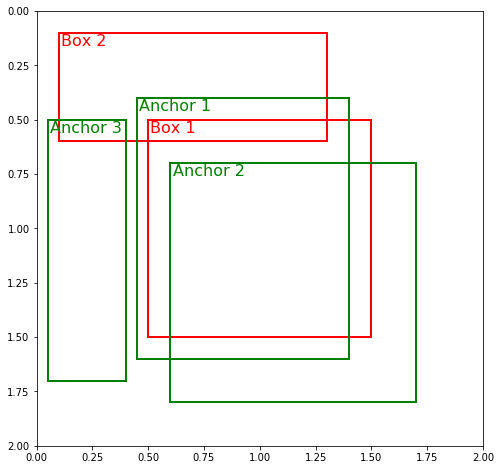

In [359]:
box1 = np.stack([0.5, 0.5, 1.5, 1.5])
box2 = np.stack([0.1, 0.1, 1.3, 0.6])
anchor1 = np.stack([0.45, 0.4, 1.4, 1.6])
anchor2 = np.stack([0.6, 0.7, 1.7, 1.8])
anchor3 = np.stack([0.05, 0.5, 0.4, 1.7])
fig, ax = plt.subplots(1, figsize=(8, 8))

def plot_labelled_box(box, ax, clr, linewidth, label):
    plot_rectangle(box, ax, clr=clr, linewidth=linewidth)
    ax.text(box[0] + 0.01, box[1] + 0.06, label, fontsize=16, color=clr)

plot_labelled_box(box1, ax, 'r', 2, 'Box 1')  
plot_labelled_box(box2, ax, 'r', 2, 'Box 2')  
plot_labelled_box(anchor1, ax, 'g', 2, 'Anchor 1')  
plot_labelled_box(anchor2, ax, 'g', 2, 'Anchor 2')  
plot_labelled_box(anchor3, ax, 'g', 2, 'Anchor 3')  
ax.set_xlim([0, 2])
ax.set_ylim([0, 2])
ax.invert_yaxis();

In [458]:
def rpn_targets(anchors, target_boxes, pos_iou_th=0.7, neg_iou_th=0.3):
    
    # Postive criterion (i)
    def _pos_max(overlaps):
        max_overlap_per_target = tf.reduce_max(overlaps, axis=-2, keepdims=True) # (1, n_boxes)
        overlap_equals_max = tf.equal(overlaps, max_overlap_per_target) # (n_anchors, n_boxes)
        pos_cond_max = tf.reduce_any(overlap_equals_max, axis=-1) # (n_anchors)
        return tf.where(pos_cond_max)[:, 0] # (n_pos_max,) - values in range [0, n_anchors)
        #return tf.argmax(overlaps, axis=-2) # (n_boxes,) - values in range [0, n_anchors)
    
    # Postive criterion (ii)
    def _pos_iou(overlaps, iou_th):
        pos_cond_iou = tf.reduce_any(tf.greater(overlaps, iou_th), axis=-1) # (n_anchors, )
        return tf.where(pos_cond_iou)[:, 0]  # (n_pos_iou, ) - values in range [0, n_anchors)

    # Negative criterion
    def _neg_iou(overlaps, iou_th):
        neg_cond_iou = tf.reduce_all(tf.less(overlaps, iou_th), axis=-1) # (n_anchors, )
        return tf.where(neg_cond_iou)[:, 0]  # (n_anchors, ) - values in range [0, n_anchors)
    
    # Target matching
    def _target_matches(overlaps, pos_ids):
        pos_overlaps = tf.gather(overlaps, pos_ids) # (n_pos, n_boxes)
        return tf.argmax(pos_overlaps, axis=-1) # (n_pos) - values in the range [0, n_boxes)
    
    anchors_shape = tf.shape(anchors)
    anchors = tf.reshape(anchors, (-1, 4))
    
    overlaps = box_iou(anchors, target_boxes) # (n_anchors, n_boxes)
    
    pos_ids_max = _pos_max(overlaps) # (n_pos_max)
    pos_ids_iou = _pos_iou(overlaps, pos_iou_th) # (n_pos_iou)
    
    pos_ids = tf.sets.set_union(pos_ids_iou[None], pos_ids_max[None]).values  # (n_pos,)
    
    neg_ids_iou = _neg_iou(overlaps, neg_iou_th)
    
    neg_ids = tf.sets.set_difference(neg_ids_iou[None], pos_ids_max[None]).values  # (n_neg,)
    
    inds = tf.to_int32(tf.concat([pos_ids, neg_ids], 0))
    values = tf.concat([tf.ones_like(pos_ids), tf.negative(tf.ones_like(neg_ids))], axis=0)
    
    labels = tf.scatter_nd(inds[:, None], values, tf.shape(anchors)[:-1])

    pos_target_ids = _target_matches(overlaps, pos_ids) # (n_pos,) - values in the range [0, n_boxes)
    
    pos_target_ids = tf.Print(pos_target_ids, data=[pos_target_ids])
    
    pos_targets = tf.gather(target_boxes, pos_target_ids)
    
    boxes = tf.scatter_nd(tf.to_int32(pos_ids)[:, None], 
                          pos_targets,
                          tf.shape(anchors)) # (n_anchors, 4)
    
    boxes = tf.reshape(boxes, anchors_shape)
    labels = tf.reshape(labels, anchors_shape[:-1])
    
    return boxes, labels, overlaps

In [459]:
aspect_ratios

(0.5, 1, 2)

In [503]:
with tf.Session() as sess:
    grid, inside = grid_anchors(generate_anchors(sizes=sizes, aspect_ratios=aspect_ratios), 
                            16, 1000//16, 600//16, img.shape[1], img.shape[0])
    anchors = tf.convert_to_tensor(grid.astype('float32'))
    
    boxes, labels, p1 = sess.run(rpn_targets(anchors, tf.convert_to_tensor([bbox1, bbox2], dtype='float32')))
    boxes2, labels2, p2 = sess.run(rpn_targets(anchors, tf.convert_to_tensor([bbox3], dtype='float32')))

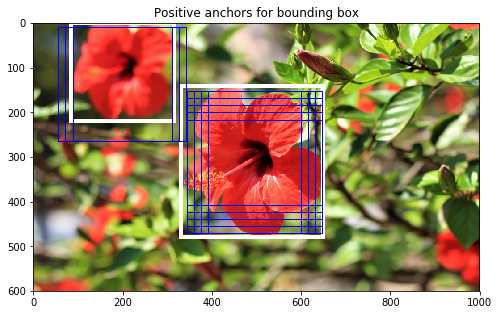

In [505]:
pos_boxes = grid[(labels==1) & (inside==1)].reshape((-1, 4))
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img)
plot_rectangle(np.stack(bbox1), ax, clr='w', linewidth=4)
plot_rectangle(np.stack(bbox2), ax, clr='w', linewidth=4)
for box in pos_boxes:
    plot_rectangle(box, ax)
ax.set_title('Positive anchors for bounding box');

> Note that for the first box in the top image several anchor boxes match due to having IoUs > 0.7 but less than the max IoU but for the second box all the boxes match via the max IoU criterion and have IoU < 0.7.

In [546]:
with tf.Session() as sess:
    overlaps = (sess.run( box_iou(tf.reshape(anchors, [-1, 4]), target_boxes)))
    print(sess.run((box_area(pos_boxes))))
    
overlaps.max(axis=0), overlaps[:, 0][overlaps[:, 0] > 0.7], overlaps[:, 1][overlaps[:, 1] == overlaps[:, 1].max(axis=0)]

[65025. 65025. 65025. 65025. 65025. 65025. 65025. 65025. 65025. 65025.
 65025. 65025. 65025. 65025. 65025. 65025. 65025. 65025. 65025. 65025.
 65025. 65025. 65025.]


(array([0.77816224, 0.59765625], dtype=float32),
 array([0.72484523, 0.74726105, 0.7303951 , 0.75441927, 0.77816224,
        0.76029533, 0.75441927, 0.77816224, 0.76029533, 0.7075746 ,
        0.7292305 , 0.7129376 ], dtype=float32),
 array([0.59765625, 0.59765625, 0.59765625, 0.59765625, 0.59765625,
        0.59765625, 0.59765625, 0.59765625, 0.59765625, 0.59765625,
        0.59765625, 0.59765625, 0.59765625, 0.59765625, 0.59765625,
        0.59765625, 0.59765625, 0.59765625, 0.59765625, 0.59765625],
       dtype=float32))

## Regression targets / "deltas"

#TODO: [Add details about the similar thing for the detector part - paper not available offline]

For bounding box regression, we adopt the param- eterizations of the 4 coordinates following [5]:

$$t_x = (x − x_a)/w_a,\text{ }\text{ }t_y = (y − y_a)/h_a \\
t_w = \log(w/w_a),\text{ }\text{ }t_h = \log(h/h_a) \\
t_x = (x^∗ − x_a)/w_a,\text{ }\text{ }t^∗_y = (y^∗ − y_a)/h_a \\
t^∗_w = \log(w^∗/w_a),\text{ }\text{ }t^∗_y = (y^∗ − y_a)/h_a \\
t^*_h = \log(h^∗/h_a),\text{ }\text{ }t^∗_h = (h^∗/h_a)$$

where $x$, $y$, $w$, and $h$ denote the box’s center coordi- nates and its width and height. Variables $x$, $x_a$, and $x^∗$ are for the predicted box, anchor box, and ground- truth box respectively (likewise for $y$, $w$, $h$). This can be thought of as bounding-box regression from an anchor box to a nearby ground-truth box

In [507]:
def boxes_to_deltas(boxes, ref):
    dims_ref = ref[..., 2:]
    coords_diff = (boxes[..., :2] - ref[..., :2]) / dims_ref
    dims_diff = boxes[..., 2:] / dims_ref
    deltas = tf.log(tf.concat([coords_diff, dims_diff], axis=-1))
    return deltas

> The outputs of the model are interpreted as deltas and targets are converted into deltas for calculating the loss. Since the model outputs deltas, to use them as boxes, we also need a function to convert the deltas into back into boxes.

In [508]:
def deltas_to_boxes(deltas, ref):
    dims_ref = ref[..., 2:]
    coords_deltas = deltas[..., :2] * dims_ref + ref[..., :2]
    dims_deltas = deltas[..., 2:] * dims_ref 
    deltas = tf.exp(tf.concat([coords_deltas, dims_deltas], axis=-1))
    return deltas

## BoxList

> Whilst training the model we need pass around various properties of RoIs, for example the class_ids, scores, anchor boxes, predicted boxes, target boxes, etc. We need to keep them together in the same order. If we select a subset of any one of these we need select corresponding subsets of the rest. To faciliate these steps we define a class BoxList that is based on a dict.

In [509]:
#TODO: redo when final configuration is decided
class BoxList(dict):
    
    def __getattr__(self, attr):
        #Allow keys to be accessed as attributes
        return self[attr]

#     def __setitem__(self, *args, **kwargs):
#         #Immutable
#         raise AttributeError('BoxList has no attribute __setitem__')

    def map(self, fn, *args, **kwargs):
        fields, arrs = zip(*self.items())

        def _fn(x, *args, **kwargs):
            x = BoxList(dict(zip(fields, x)))
            x_new = fn(x, *args, **kwargs)
            return tuple(x_new[field] for field in fields)

        arrs_new = tf.map_fn(elems=arrs, fn=_fn)
        return BoxList(dict(zip(fields, arrs_new)))
    
    # TODO: should there be a boxlist_concat instead
    def concat(self, other):
        if not (set(self) == set(other)):
            raise ValueError('Can only concatenate BoxLists with the same fields')
        _fields = {}
        for field in self:
            _fields[field] = tf.concat([self[field], other[field]], axis=0)
        return BoxList(_fields)

    def masked_select(self, keep):
        _fields = {}
        for field, arr in self.items():
            _fields[field] = tf.boolean_mask(arr, keep)
        return BoxList(_fields)
    
    def pad(self, pad_size):
        _fields = {}
        
        for field, arr in self.items():
            pad = tf.zeros([tf.rank(arr)-1, 2], dtype=tf.int32)
            padding = tf.concat([
                tf.stack([[0, pad_size]]),
                pad], axis=0)
            _fields[field] = tf.pad(arr, padding)
        return BoxList(_fields)

    def select(self, inds):
        _fields = {}
        for field, arr in self.items():
            _fields[field] = tf.gather(arr, inds)
        return BoxList(_fields)
    
    def select_fields(self, fields):
        return BoxList({field: self[field] for field in fields})
    
    
def boxlist_stack(boxlists):
    first_dim_size = [tf.shape(list(b.values())[0])[0] for b in boxlists]
    max_size = tf.reduce_max(first_dim_size)
    boxlists = [b.pad(max_size - fsize) for b, fsize in zip(boxlists, first_dim_size)]
    _fields = {}
    for field in boxlists[0].keys():
        _fields[field] = tf.stack([boxlist[field] for boxlist in boxlists])
    return BoxList(_fields)

In [510]:
sess = tf.Session()
blist1 = BoxList(boxes=tf.stack([bbox1, bbox2]), scores=tf.stack([1, 2]))
blist2 = BoxList(boxes=tf.stack([bbox3]), scores=tf.stack([3]))

sess.run([blist1, blist2, boxlist_stack([blist1, blist2])])

[{'boxes': array([[ 85,   0, 315, 220],
         [330, 140, 650, 480]], dtype=int32),
  'scores': array([1, 2], dtype=int32)},
 {'boxes': array([[130, 150, 505, 440]], dtype=int32),
  'scores': array([3], dtype=int32)},
 {'boxes': array([[[ 85,   0, 315, 220],
          [330, 140, 650, 480]],
  
         [[130, 150, 505, 440],
          [  0,   0,   0,   0]]], dtype=int32), 'scores': array([[1, 2],
         [3, 0]], dtype=int32)}]

In [511]:
sess.run(blist1.masked_select(tf.equal(blist1.scores, 2)))

{'boxes': array([[330, 140, 650, 480]], dtype=int32),
 'scores': array([2], dtype=int32)}

In [512]:
sess.run(blist1.select([0]))

{'boxes': array([[ 85,   0, 315, 220]], dtype=int32),
 'scores': array([1], dtype=int32)}

In [513]:
sess.run(blist1.concat(blist2))

{'boxes': array([[ 85,   0, 315, 220],
        [330, 140, 650, 480],
        [130, 150, 505, 440]], dtype=int32),
 'scores': array([1, 2, 3], dtype=int32)}

In [514]:
sess.run(blist1.map(lambda x: x))

{'boxes': array([[ 85,   0, 315, 220],
        [330, 140, 650, 480]], dtype=int32),
 'scores': array([1, 2], dtype=int32)}

In [515]:
sess.run(blist1.map(lambda x: BoxList(boxes=x.scores * x.boxes, scores=x.scores) ))

{'boxes': array([[  85,    0,  315,  220],
        [ 660,  280, 1300,  960]], dtype=int32),
 'scores': array([1, 2], dtype=int32)}

# Training RPNs

The RPN can be trained end-to-end by back- propagation and stochastic gradient descent (SGD) [35]. We follow the “image-centric” sampling strategy from [2] to train this network. Each mini-batch arises from a single image that contains many positive and negative example anchors. It is possible to optimize for the loss functions of all anchors, but this will bias towards negative samples as they are dominate. Instead, we randomly sample 256 anchors in an image to compute the loss function of a mini-batch, where the sampled positive and negative anchors have a ratio of up to $1:1$. If there are fewer than 128 positive samples in an image, we pad the mini-batch with negative ones.

In [535]:
#TODO: potentially modify for use in detector
def sample_proposals(boxlist, num_samples=256):
    samples = []
    inds = [tf.where(tf.logical_and(tf.equal(boxlist.target_labels, label),
                                    tf.equal(boxlist.inside, 1))) 
            for label in [1, -1]]
    nums = [num_samples//2, num_samples - tf.shape(inds[0])[0]]
    for ind, num in zip(inds, nums):
        sample_inds = tf.random.shuffle(inds)[:num]
        samples.append(boxlist.select(sample_inds))
    samples = samples[0].concat(samples[1])
    return samples #.pad(num_samples)

Our loss function for an image is defined as

$$L(\{p_i\}, \{t_i\}) = \frac{1}{N_{cls}} \sum_i L_{cls}(p_i, p_i^*) + \lambda\frac{1}{N_{reg}} \sum_i p_i^* L_{reg}(t_i, t_i^*) $$

Here, i is the index of an anchor in a mini-batch and pi is the predicted probability of anchor i being an object. The ground-truth label $p_i^∗$ is 1 if the anchor
is positive, and is 0 if the anchor is negative. ti is a vector representing the 4 parameterized coordinates of the predicted bounding box, and $t_i^∗$  is that of the
ground-truth box associated with a positive anchor. The classification loss Lcls is log loss over two classes (object vs. not object). For the regression loss, we use $L_{reg}(t_i, t_i^∗) = R(t_i − t_i^*)$ where $R$ is the robust loss function (smooth $L_1$) defined in [2]. The term $p_i^∗ L_{reg}$ means the regression loss is activated only for positive anchors $(p_i^* = 1)$ and is disabled otherwise $(p_i^* = 0)$. The outputs of the cls and reg layers consist of $\{p_i\}$ and $\{t_i\}$ respectively.

The two terms are normalized by $N_{cls}$ and $N_{reg}$ and weighted by a balancing parameter $\lambda$. In our current implementation (as in the released code), the cls term in Eqn.(1) is normalized by the mini-batch size (i.e., $N_{cls}$ = 256) and the reg term is normalized by the number of anchor locations (i.e., $N_{reg}$ = 2400). By default we set $\lambda = 10$, and thus both cls and reg terms are roughly equally weighted. We show by experiments that the results are insensitive to the values of $\lambda$ in a wide range (Table 9). We also note that the normalization as above is not required and could be simplified

In [550]:
def rpn_class_loss(samples):
    losses = tf.nn.sigmoid_cross_entropy_with_logits(logits=samples.scores, 
                                                   labels=samples.target_labels)
    # Mean equivalent to normalizing by mini-batch size
    return tf.reduce_mean(losses)
    
def rpn_reg_loss(samples, denom=None, reg_lambda=None):
    boxlist = boxlist.select(tf.equal(samples.target_labels, 1))
    losses = tf.losses.huber_loss(predictions=samples.deltas, 
                                labels=samples.target_boxes,
                                reduction=None)
    if reg_lambda is not None:
        losses = losses * reg_lambda
        
    if denom is not None:
        return tf.reduce_sum(losses) / denom
    
    return tf.reduce_mean(losses)

def rpn_loss(boxlist, num_samples, reg_lambda=None, num_reg=False):
    samples = sample_proposals(boxlist, num_samples)
    if num_reg:
        denom = tf.shape(boxlist.deltas)[0]
    else:
        denom = None
    return {'rpn_class_loss': rpn_class_loss(samples),
            'rpn_reg_loss'  : rpn_reg_loss(samples, denom, reg_lambda)}

# Non-maximum suppression



To reduce redundancy, we adopt non-maximum suppression (NMS) on the proposal regions based on their cls scores. We fix the IoU threshold for NMS at 0.7, which leaves us about 2000 proposal regions per image.

In [551]:
def boxlist_nms(boxlist, max_output_size, iou_threshold=0.7):
    keep = tf.image.non_max_suppression(boxlist.boxes, boxlist.scores,
            max_output_size=max_output_size, 
            iou_threshold=iou_threshold)
    boxlist = boxlist.select(keep)
    boxlist = boxlist.pad(max_output_size)
    return boxlist

## Putting it all together

In [552]:
def build_rpn(config, inputs):
    anchors, inside = pyramid_anchors(config.rpn.strides, 
                              config.rpn.sizes, 
                              config.rpn.aspect_ratios, 
                              config.rpn.img_width, 
                              config.rpn.img_height)
    anchors = tf.reshape(anchors, [-1, 4])
    inside = tf.reshape(inside, [-1])
    deltas, scores = rpn_head(inputs)
    target_boxes, target_labels = rpn_targets(anchors, target_boxes, 
                                              pos_iou_th=config.rpn.pos_iou_th,
                                              neg_iou_th=config.rpn.neg_iou_th)
    boxlist = BoxList(scores=scores,
                    anchors=anchors, 
                    inside=inside, 
                    deltas=deltas,
                    target_boxes=target_boxes,
                    target_labels=target_labels)
    
    rpn_losses = rpn_loss(boxlist, config.rpn.num_samples, config.rpn.num_reg)
    
    return boxlist, rpn_losses

## Fast R-CNN


### Overview
A Fast R-CNN network takes as input an entire image and a set of object proposals. The network first processes the whole image with several convolutional (conv) and max pooling layers to produce a conv feature map. Then, for each ob- ject proposal a region of interest (RoI) pooling layer ex- tracts a fixed-length feature vector from the feature map. Each feature vector is fed into a sequence of fully connected (fc) layers that finally branch into two sibling output lay- ers: one that produces softmax probability estimates over K object classes plus a catch-all “background” class and another layer that outputs four real-valued numbers for each of the K object classes. Each set of 4 values encodes refined bounding-box positions for one of the K classes.

In [ ]:
# TODO: add picture

### RoIPool

The RoI pooling layer uses max pooling to convert the
features inside any valid region of interest into a small fea- ture map with a fixed spatial extent ofH×W (e.g., 7 × 7), where H and W are layer hyper-parameters that are inde- pendent of any particular RoI. In this paper, an RoI is a rectangular window into a conv feature map. Each RoI is defined by a four-tuple (r, c, h,w) that specifies its top-left corner (r, c) and its height and width (h,w).

RoI max pooling works by dividing the h × w RoI win-
dow into an H × W grid of sub-windows of approximate size h/H ×w/W and then max-pooling the values in each sub-window into the corresponding output grid cell. Pool- ing is applied independently to each feature map channel, as in standard max pooling. The RoI layer is simply the special-case of the spatial pyramid pooling layer used in SPPnets [11] in which there is only one pyramid level. We use the pooling sub-window calculation given in [11].
2.2.

[From the SPPnets paper] Consider the feature maps after conv5 that have a size
of a×a (e.g., 13×13). With a pyramid level of n×n
bins, we implement this pooling level as a sliding
window pooling, where the window size win = da/ne
and stride str = ba/nc with d·e and b·c denoting
ceiling and floor operations. W

In [1047]:
def crop_bbox(image, bbox, incl=True):
    x1, y1, x2, y2 = bbox
    return image[y1:y2 + incl, x1:x2 + incl]

def roi_pool(image, bbox, pool_width, pool_height):
    pool_size = np.stack([pool_width, pool_height])
    bbox = np.round(bbox)
    x1, y1, x2, y2 = bbox
    
    sizes = (bbox[..., 2:] - bbox[..., :2]) + 1
    x_win, y_win = np.ceil(sizes / pool_size).astype('int')
    x_str, y_str = np.floor(sizes / pool_size).astype('int')
    
    pooled = np.zeros((pool_height, pool_width, image.shape[-1]))
    
    for x in np.arange(pool_width):
        x_start = x * x_str + x1
        x_end = x_start + x_win
        bb = []
        crop = []
        for y in np.arange(pool_height):
            y_start = y * y_str + y1
            y_end = y_start + y_win
            pool_window = image[y_start: y_end, x_start: x_end]
            pooled[y, x] = np.max(pool_window, axis=(0, 1))

            
    return pooled

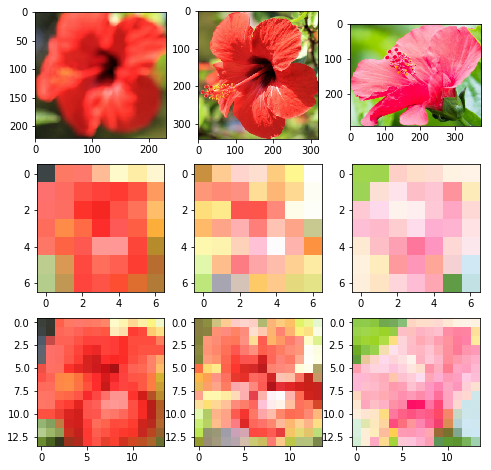

In [1048]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, (bbox, im) in enumerate(zip([bbox1, bbox2, bbox3], [img, img, img2])): 
    axes[0][i].imshow(crop_bbox(im, bbox))
    axes[1][i].imshow(roi_pool(im, bbox, 7, 7))
    axes[2][i].imshow(roi_pool(im, bbox, 14, 14))

> As far as I am aware there isn't an efficient way to implement RoIPool in TensorFlow. In particular there is no op for this (although there are unofficial implementations). Since we want to implement Mask-RCNN shall instead use RoIAlign a pooling method introduced for instance segmentation using Mask-RCNN which was actually shown to perform better for object detection as well. 

## RoIAlign

RoIPool [12] is a standard operation for extract- ing a small feature map (e.g., 7×7) from each RoI. RoIPool first quantizes a floating-number RoI to the discrete granu- larity of the feature map, this quantized RoI is then subdivided into spatial bins which are themselves quantized, and finally feature values covered by each bin are aggregated (usually by max pooling). Quantization is performed, e.g., on a continuous coordinate x by computing [x/16], where 16 is a feature map stride and [·] is rounding; likewise, quantization is performed when dividing into bins (e.g., 7×7). These quantizations introduce misalignments between the RoI and the extracted features. While this may not impact classification, which is robust to small translations, it has a large negative effect on predicting pixel-accurate masks.

To address this, we propose an RoIAlign layer that removes the harsh quantization of RoIPool, properly aligning the extracted features with the input. Our proposed change is simple: we avoid any quantization of the RoI boundaries or bins (i.e., we use x/16 instead of [x/16]). We use bilinear interpolation [22] to compute the exact values of the input features at four regularly sampled locations in each RoI bin, and aggregate the result (using max or average), see Figure 3 for details. We note that the results are not sensitive to the exact sampling locations, or how many points are sampled, as long as no quantization is performed.

> They note elsewhere that RoIAlign leads to better performance compared with RoIPool. 

[W]e trained a version of Mask R-CNN but without the mask branch, denoted by “Faster R-CNN, RoIAlign” in Table 3. This model performs better than the model presented in [27] due to RoIAlign.

>### Note on the implementation
> TensorFlow does not have a native RoIAlign op so I looked at the C++ op implemented for Facebook's official implementation in PyTorch and recreated it using high-level ops. It consists of two steps:
1. Generate the points at which to sample the image.
2. Interpolate the image at these points. 
>
>There is a bilinear interpolation op in `tf.contrib` but it doesn't appear to have made it into TF 2.0 so I have included a version of the interpolation function from Facebook repo as well. The version using `tf.contrib.resampler.resampler` has differences for corner cases e.g. where the bounding box is invalid or lies (partly) outside the image but I expect that these will not occur frequently.



In [1049]:
def sampling_points(image, rois, spatial_scale, sampling_ratio, pool_height, pool_width):
    # S = samples per bin in each direction / sampling_ratio
    # P = pool_size 
    # N = number of rois
    
    pool_dims = tf.stack([pool_width, pool_height])
    
    # Rescale rois
    rois = rois * spatial_scale # (N, 4)
    
    # Get dims
    roi_dims = tf.maximum(rois[..., 2:] - rois[..., :2], 1.)
    
    # Get number of bins
    bin_sizes = roi_dims / tf.cast(pool_dims, tf.float32) # (N, 2)
    
    bin_grid_dims = tf.tile([sampling_ratio], [2])
    count = tf.reduce_prod(bin_grid_dims, axis=-1)
    
    iy = tf.cast(tf.range(bin_grid_dims[..., 1]), tf.float32) # (S,)
    ix = tf.cast(tf.range(bin_grid_dims[..., 0]), tf.float32) # (S,)
    
    ixy = tf.reshape(tf.stack(tf.meshgrid(ix, iy, indexing='xy'), axis=-1), (-1, 2)) # (S^2, 2)
    
    ph = tf.cast(tf.range(pool_height), tf.float32) # (P,)
    pw = tf.cast(tf.range(pool_width), tf.float32) # (P,)
    
    pool_range = tf.stack(tf.meshgrid(pw, ph, indexing='xy'), axis=-1) # (P, P, 2)
    
    # Which bin
    # (1, P, P, 2) + (N, 1, 1, 2) -> (N, P, P, 2)
    bin_shift = pool_range[None] * bin_sizes[:, None, None]
    
    # Which cell in the bin to sample from 
    # (N, 2)
    bin_sampling_cell_size = bin_sizes / tf.cast(bin_grid_dims, tf.float32)
    
    # (ixy + 0.5) gives the cell centres for a 1 x 1 grid e.g. 0.5, 1.5, etc.
    # We scale it by the cell size
    # (N, S^2, 2)
    sampling_point_shift = (ixy + 0.5)[None] * bin_sampling_cell_size[:, None]
    
    # First we go to the bin from the starting coordinate, then to the cell centre from there
    # (N, 1, 1, 1, 2) + (N, P, P, S^2, 2) + (N, 1, 1, S^2, 2) -> (N, P, P, S^2, 2)
    xxyy = rois[...,:2][:, None, None, None] + bin_shift[:, :, :, None] + sampling_point_shift[:, None, None]
    
    return xxyy

def interpolate(image, points, box_ind):
    # S = samples per bin in each dim
    # P = pool size
    # C = channels in image
    # N = number of rois
     
    # (2,)
    dims = tf.stack(image.shape[1:3][::-1])
    # (N, P, P, S^2, 2) -> (N, P, P, S^2, 1) -> (N, P, P, S^2, 2) 
    pos_cond = tf.tile(tf.reduce_any(tf.logical_or(tf.less(points, -1.), 
                                                   tf.greater(points, tf.cast(dims, tf.float32)) ), axis=-1, 
                                     keepdims=True), 
                       [1, 1, 1, 1, 2])
    
    points = tf.maximum(points, 0)
   
    # (N, P, P, S^2, 2)
    xy_low = tf.cast(points, tf.int32)
    # (N, P, P, S^2, 2)
    cond = tf.greater_equal(xy_low, dims - 1)
    
    # If xy_low is outside the image, upper bound xy_high 
    # to the highest image co-ordinates
    # All (N, P, P, S^2, 2)
    dims_minus_1 = (dims - 1) * tf.ones_like(xy_low)
    xy_high = tf.where(cond, dims_minus_1, xy_low + 1)
    xy_low = tf.where(cond, dims_minus_1, xy_low)
    xy = tf.where(cond, tf.cast(xy_low, tf.float32), points)
    
    # This will be 0 if condition is True otherwise it is the distance 
    # to the nearest integer pixel before the sampling point 
    # (N, P, P, S^2, 2)
    lxy = xy - tf.cast(xy_low, tf.float32)
    # This will be 1 if condition is True otherwise it is the nearest
    # integer pixel after the sampling point
    # (N, P, P, S^2, 2)
    hxy = 1. - lxy

    # All (N, P, P, S^2, 2)
    xy_low = tf.where(pos_cond, tf.zeros_like(xy_low), xy_low)
    xy_high = tf.where(pos_cond, tf.zeros_like(xy_low), xy_high)
    lxy = tf.where(pos_cond, tf.zeros_like(lxy), lxy)
    hxy = tf.where(pos_cond, tf.zeros_like(hxy), hxy)

    # batch_inds[i] of shape (P, P, S^2) will all be box_ind[i]
    # (N, P, P, S^2) * # (N, 1, 1, 1) -> (N, P, P, S^2)
    batch_inds = tf.ones_like(xy_low[..., 0]) * box_ind[:, None, None, None]
    
    # Indices of points for bilinear interpolation
    # (3, N, P, P, S^2, 4)
    inds = tf.stack(
               [[batch_inds, xy_low[..., 1], xy_low[..., 0]],
                [batch_inds, xy_low[..., 1], xy_high[..., 0]],
                [batch_inds, xy_high[..., 1], xy_low[..., 0]],
                [batch_inds, xy_high[..., 1], xy_high[..., 0]]], axis=-1)
    
    # (N, P, P, S^2, 4, 3)
    inds = tf.transpose(inds, (1, 2, 3, 4, 5, 0))
    
    # (N, P, P, S^2, 4, C)
    known_points = tf.gather_nd(image, inds)
    
    # Weights for bilinear interpolation
    # (N, P, P, S^2, 4)
    weights = tf.stack([
        (hxy[..., 1] * hxy[..., 0]),
        (hxy[..., 1] * lxy[..., 0]),
        (lxy[..., 1] * hxy[..., 0]),
        (lxy[..., 1] * lxy[..., 0])
    ], axis=-1)
    
    # (N, P, P, S^2, C)
    samples = tf.reduce_sum(known_points * weights[..., None], axis=-2)
    
    return samples
    
def roi_align(image, rois, box_ind, spatial_scale, sampling_ratio, pool_height, pool_width,
             interp='resampler'):
    # S = samples per bin in each dim
    # P = pool size
    # C = channels in image
    # N = number of rois
    points = sampling_points(image, rois, spatial_scale, sampling_ratio, pool_height, pool_width)
    if interp=='resampler':
        # (N, P, P, S^2, C)
        samples = tf.contrib.resampler.resampler(data=tf.gather(image, box_ind), warp=points)
    else:
        # (N, P, P, S^2, C)
        samples = interpolate(image, points, box_ind)
    # (N, P, P, C)
    return tf.reduce_mean(samples, axis=-2)

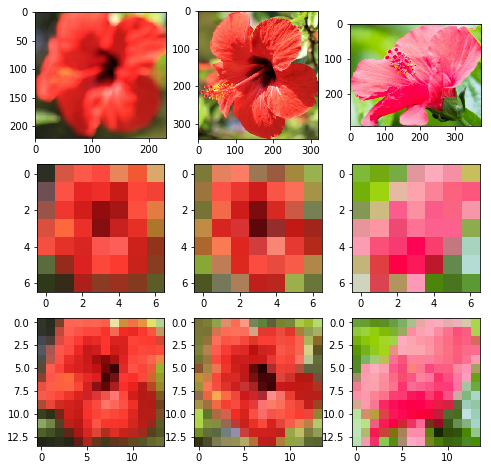

In [1056]:
with tf.Session() as sess:
    imgs = np.stack([img, img2]).astype('float32')
    bboxes = np.stack([bbox1, bbox2, bbox3])
    bboxes = bboxes.astype('float32')
    box_inds = np.stack([0, 0, 1])
    pool1 = sess.run(roi_align(imgs, bboxes, box_inds, 1, 2, 7, 7))
    pool2 = sess.run(roi_align(imgs, bboxes, box_inds, 1, 2, 14, 14))
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for i, (bbox, ind) in enumerate(zip(bboxes, box_inds)): 
        im = imgs[ind]
        axes[0][i].imshow(crop_bbox(im, bbox.astype('int')))
        axes[1][i].imshow(pool1[i])
        axes[2][i].imshow(pool2[i])

In [1058]:
# TODO:
# [] Config
# [] Detector heads
# [] Post-processing for detector